<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/HAR_CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-217227753.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-217227753.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-217227753.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-217227753.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, BatchNormalization,
    Dropout, GRU, Dense
)

# n_timesteps, n_features, n_outputs 가 이미 정의돼 있다고 가정
cnn_gru = Sequential([
    Input(shape=(n_timesteps, n_features)),  # (T, F)

    # --- CNN feature extractor ---
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # --- Sequence modeling (GRU) ---
    GRU(128),

    # --- Classifier ---
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_outputs, activation='softmax')
])

cnn_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,742 (612.27 KB)

 Trainable params: 156,358 (610.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model_history=cnn_gru.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.7521 - loss: 0.6377 - val_accuracy: 0.3107 - val_loss: 2.7547
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9266 - loss: 0.1741 - val_accuracy: 0.8387 - val_loss: 0.5569
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9403 - loss: 0.1393 - val_accuracy: 0.9372 - val_loss: 0.1166
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9524 - loss: 0.1213 - val_accuracy: 0.9508 - val_loss: 0.1057
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9468 - loss: 0.1309 - val_accuracy: 0.9457 - val_loss: 0.1086
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9445 - loss: 0.1310 - val_accuracy: 0.9542 - val_loss: 0.1192
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9505 - loss: 0.1191 - val_accuracy: 0.9610 - val_loss: 0.1034
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9459 - loss: 0.1259 - 

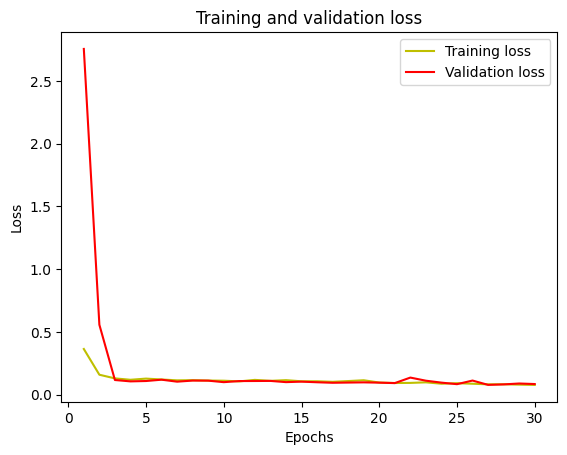

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

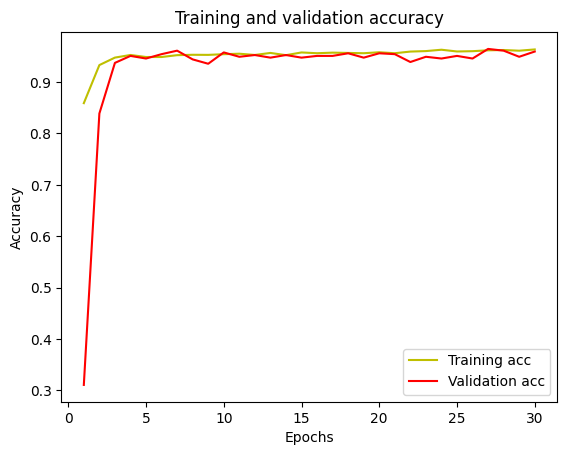

In [ ]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
[[495   1   0   0   0   0]
 [  0 468   3   0   0   0]
 [  2   6 412   0   0   0]
 [  0  24   0 422  45   0]
 [  0   0   0 102 430   0]
 [  0   0   0   0   0 537]]
0.9379029521547336
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       0.94      0.99      0.96       471
           2       0.99      0.98      0.99       420
           3       0.81      0.86      0.83       491
           4       0.91      0.81      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

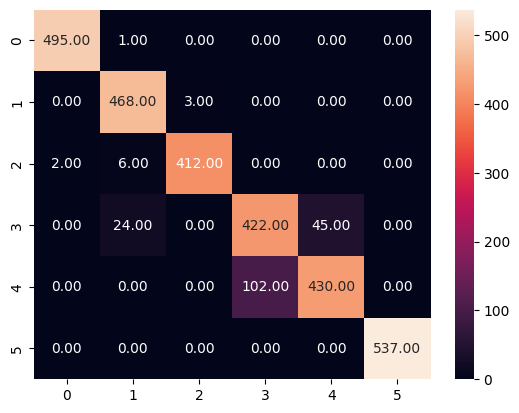

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn_gru.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')